# TP 2 - Séance 2
## Apprentissage profond appliqué aux images médicales

Équipe #22
- Beaudry, Sophie (2140839)
- Lachapelle, Vincent (2206192)

In [52]:
import gc
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import load_dataset, disable_caching
from pcam_utils import get_dataloaders, get_model_and_optimizer, train_epoch, validate
from tqdm.auto import tqdm  # Pour faire des jolies barres de progression


disable_caching()  # Ne modifiez pas cette ligne!

# Exercice III : Classification d'images histologiques

Le jeu de données `dataset` est un objet de type [`DatasetDict`](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.DatasetDict) organisé comme un `dict` standard en Python, avec des entrées nommées `"train"`, `"validation"`, et `"test"` et qui contiennent des [`Dataset`](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset) - qui eux contiennent les images et leur label associé.

Vous pouvez interagir avec un `DatasetDict` essentiellement de la même manière qu'avec un `dict` (e.g. les méthodes `keys()`/`values()`/`items()`, aller chercher une entrée avec la notation par crochets `dataset["train"]`, etc.).

Pour interagir avec un `Dataset`, vous pouvez soit aller chercher un exemple donné (e.g. `dataset["train"][0]` qui est un `dict` qui contient une image et son label), soit aller chercher **tous** les labels/images du dataset (e.g. `dataset["train"]["label"]`).

<span style="color:red">**Attention!** Si vous essayez de charger toutes les images d'un coup, ça ne machera probablement pas car il y en a beaucoup trop pour la quantité de RAM qui est vraisemblablement disponible sur votre machine.
</span>

In [5]:
# Ne modifiez pas cette cellule!
dataset = load_dataset("zacharielegault/PatchCamelyon")

Generating test split: 100%|██████████| 32768/32768 [00:00<00:00, 131072.13 examples/s]


## Exploration des données
**Q1**. Combien d'images y a-t-il dans chaque sous-ensemble du dataset?

In [9]:
lengths = {key: len(dataset[key]) for key in dataset.keys()}

for key in dataset.keys():
    print(f"La taille du sous-ensemble '{key}' est de {lengths[key]} images.")

La taille du sous-ensemble 'train' est de 262144 images.
La taille du sous-ensemble 'validation' est de 32768 images.
La taille du sous-ensemble 'test' est de 32768 images.


**Q2**. Quelles sont les classes représentées dans le dataset? Comment sont-elles représentées?

In [16]:
print(np.unique(dataset["train"]["label"]))

[0 1]


Il y a deux classes: la présence ou l'absence de tissus cancéreux. elles sont représentées par soit un 0 soit un 1.

**Q3**. Quel nombre et proportion des images de chaque sous-ensemble appartient aux différentes classes? Affichez un histogramme de la distribution des classes pour chaque sous-ensemble.

N.B.: Vous pouvez utiliser l'argument `edgecolor="black"` (e.g. `plt.hist(..., edgecolor="black")` ou `ax.hist(..., edgecolor="black")`) pour tracer une ligne noire autour des bandes de votre histogramme. Ceci pourrait rendre la lecture des histogrammes plus facile.


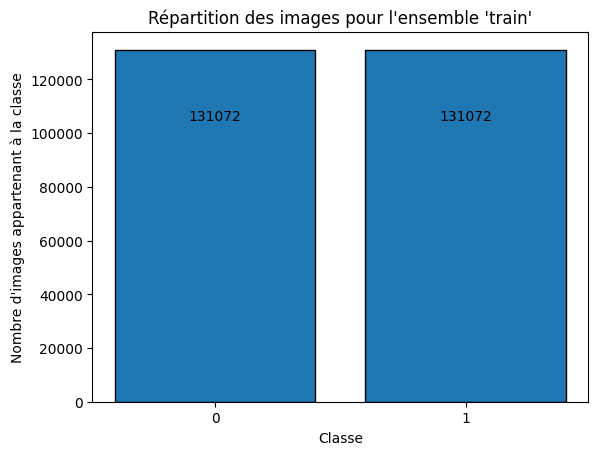

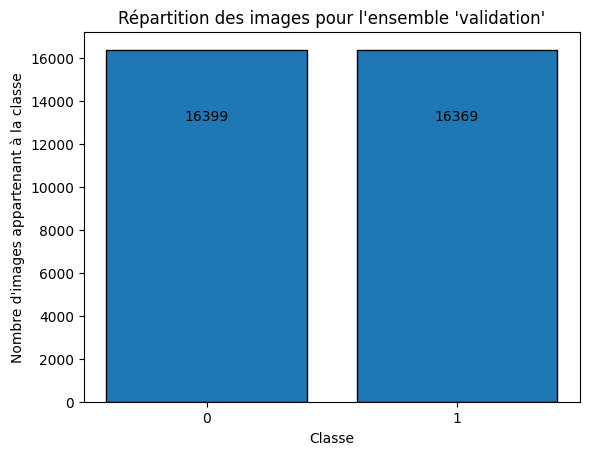

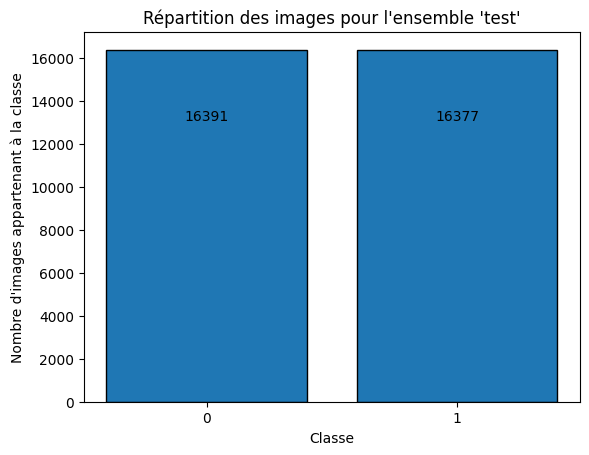

In [ ]:
for key in dataset.keys():
    unique, counts = np.unique(dataset[key]["label"], return_counts=True)
    fig, ax = plt.subplots(1,1)
    ax.bar([0, 1], counts,edgecolor='black')
    ax.set_title(f"Répartition des images pour l'ensemble '{key}'")
    ax.set_xlabel("Classe")
    ax.set_ylabel("Nombre d'images appartenant à la classe")
    ax.set_xticks(range(len(unique)), unique)
    for i, count in enumerate(counts):
        ax.text(i, count * 0.9, f"{count}", horizontalalignment='center')

**Q4**. Affichez un échantillon de l'ensemble d'entraînement. Assurez vous que votre échantillon contienne au moins 2 images de chaque classe. Affichez l'indice et la classe de chaque image.

In [ ]:
taille_echantillon = 4

indexes_by_class = {0: [], 1: []}

for index, label in enumerate(dataset["train"]["label"]):
    indexes_by_class[label].append(index)

echantillon_0 = np.random.choice(indexes_by_class[0], size=math.floor(taille_echantillon/2.0), replace=False).tolist()
echantillon_1 = np.random.choice(indexes_by_class[1], size=math.ceil(taille_echantillon/2.0), replace=False).tolist()

echantillon = echantillon_0 + echantillon_1
echantillon = [(index, dataset["train"]["image"][index], dataset["train"]["label"][index]) for index in echantillon]
print(echantillon)


## Petite note sur les fonctions fournies

### `get_model_and_optimizer`
Crée un modèle et son optimiseur. Cette fonction prend 2 arguments: un float `lr` (le taux d'apprentissage ou *learning rate*) et un booléen optionnel `pretrained` (pour indiquer si le modèle a été pré-entraîné sur l'ensemble [ImageNet](https://en.wikipedia.org/wiki/ImageNet) ou s'il a été initialisé aléatoirement).

### `get_dataloaders`
Crée trois dataloaders (qui permettent d'itérer sur un dataset et qui devront être passées à `train_epoch` et `validate`) -- un pour chaque sous-ensemble (entraînement, validation, test). Cette fonction attend deux argument obligatoires: un `DatasetDict` (le dataset qu'on a créé plus haut) et un entier `batch_size` (qui détermine combien d'exemples le modèle traitera à chaque itération).

Quelques notes additionnelles sur cette fonction:
1. En général, il est préférable d'utiliser la plus grande *batch size* possible qui entre en mémoire sur votre GPU. Vous pouvez expérimenter avec différentes valeurs (typiquement par puissances de 2) jusqu'à ce que vous trouviez une valeur qui fonctionne, mais une *batch size* de 128 devrait être suffisante et entrer en mémoire de la plupart des GPU.
2. La fonction offre un paramètre optionnel `train_subset` qui est un float compris entre 0 et 1 qui vous permet de réduire la taille de l'ensemble d'entraînement.

### `train_epoch`
Entraîne le modèle sur une époque. Elle prend 3 arguments: le modèle, le dataloader d'entraînement, et l'optimiseur. Elle retourne la liste des valeurs de *loss* à chaque itération (par batch).

### `validate`
Évalue le modèle sur un ensemble de données. Elle prend 2 arguments: le modèle et un dataloader. Elle retourne deux floats et une liste d'entiers: la valeur de *loss*, la précision (*accuracy*), et les prédictions du modèle sur l'ensemble qu'on valide.

À noter que cette fonction peut techniquement être utilisée avec n'importe quel dataloader, pas nécessairement celui de validation. Cela pourrait être utile pour évaluer le modèle sur l'ensemble d'entraînement ou l'ensemble de test...

## (Sur-)entraînement d'un modèle

Une approche fréquemment recommandée pour valider qu'une architecture donnée est correctement implémentée et qu'elle est effectivement capable d'apprendre quelque chose est d'utiliser un tout petit sous-ensemble des données d'entraînement et de volontairement sur-entraîner (*overfitting*) jusqu'à convergence sur ce sous-ensemble.

**Q5**. Créez un modèle qui n'a pas été pré-entraîné (utilisez les valeurs par défaut de **pretrained** et **lr**). Sur-entraînez le sur 1% des données d'entraînement (50 époques devraient suffire). Affichez la courbe d'évolution de votre erreur (*loss*) d'entraînement. Évaluez ensuite sur le même sous-ensemble (i.e. avec le même dataloader) et affichez la *loss* et l'accuracy finales.

In [ ]:
overfit_loader, val_loader, test_loader = get_dataloaders(dataset, batch_size=128, train_subset=0.01)

**Q6**. Que pouvez-vous conclure sur les capacités d'apprentissage de votre modèle?

**Q7**. Quelles sont les performances de ce modèle sur-entraîné sur l'ensemble de validation?

## Variation du taux d'apprentissage

<span style="color:red">**Attention !** Pour la suite du TP on veut utiliser le plus d'images possible du dataset, mais en faisant un compromis avec le temps d'entraînement. Le temps que vous écriviez votre code et que vous le testiez, vous pouvez utiliser une petite proportion des données. Toutefois pour le rendu final, utilisez **un minimum de 25%** des données d'entraînement. Vous devrez créer de nouveaux dataloaders avec la proportion appropriée.</span>

Un des paramètres essentiels dans l'entraînement d'un modèle est le taux d'apprentissage (*learning rate*), qui détermine la taille du pas qu'on prend lors de la descente de gradient pour optimiser un modèle.

**Q8**. Entraînez 3 modèles avec respectivement un *learning rate* de `1`, `1e-3`, et `1e-6`. Assurez-vous de laisser l'argument `pretrained` de la fonction `get_model_and_optimizer` à sa valeur par défaut de `False`. Durant l'entraînement de chaque modèle, faites une sauvegarde du modèle lorsque vous obtenez la meilleure accuracy. Affichez les courbes d'évolution de votre *loss* d'entraînement (par batch), et de votre *loss* et *accuracy* de validation (par époque).

Pour sauvegarder un modèle, vous pouvez utiliser la syntaxe suivante:
```py
torch.save(model.state_dict(), f"mon_modèle.pt")
```
La méthode `state_dict()` d'un modèle PyTorch retourne un `dict` qui contient les poids du modèle, tandis que la fonction `torch.save` permet de sauvegarder un tenseur (ou une collection de tenseurs comme un `dict`) sous un nom de fichier donné.

Pour charger un modèle à partir d'une sauvegarde, il faut d'abord créer un modèle identique, charger le `dict` des poids depuis le fichier, puis charger le `dict` de poids dans le modèle.
```py
saved_model = get_model_and_optimizer(pretrained=False)[0]
saved_state_dict = torch.load("mon_modèle.pt", map_location="cpu")
saved_model.load_state_dict(saved_state_dict)
```

In [6]:
train_loader, val_loader, test_loader = get_dataloaders(dataset, batch_size=128, train_subset=0.25)

**Q9**. Que pouvez-vous conclure sur l'impact du taux d'apprentissage sur l'entraînement de votre modèle? Quel est le meilleur taux d'apprentissage pour ce problème?


**Q10**. Comparez votre meilleur modèle avec celui qu'on a sur-entraîné plus tôt avec le sous-ensemble de 1%. Comment expliquez-vous les différences de performance ?

## Apprentissage par transfert
Une technique standard pour améliorer les performances d'un modèle est d'utiliser l'apprentissage par transfert (*transfer learning*) où on utilise un modèle qui a préalablement été entraîné sur une grande quantité de données à résoudre une tâche connexe à la nôtre. On procède à un affinage (*finetuning*) de ce modèle sur des nouvelles données pour le spécialiser sur une nouvelle tâche.

**Q11**. Étant données les différences marquées entre les caractéristiques des images d'ImageNet (des chats, des chiens, des autobus, des spatules, etc.) et les images histologiques (des cellules colorées), pensez-vous qu'utiliser un modèle pré-entraîné sur ImageNet va aider vos performances de classification? Expliquez votre raisonnement.


**Q12**. Affinez pendant au moins 10 époques un modèle pré-entraîné. Créez le en utilisant l'argument `pretrained=True`. Utilisez le *learning rate* qui vous a donné les meilleures performances à l'exercice précédent. Durant l'entraînement du modèle, faites une sauvegarde du modèle lorsque vous obtenez la meilleure accuracy. Affichez les courbes d'évolution de votre *loss* d'entraînement, et de votre *loss* et *accuracy* de validation.

**Q13**. Comparez les performances de votre modèle pré-entraîné avec celles de votre modèle non pré-entraîné. Qu'en concluez-vous?

## Évaluation finale
Jusqu'à présent on n'a évalué le modèle que sur le sous-ensemble de validation. Pour obtenir une évaluation finale de notre modèle, on doit l'évaluer sur l'ensemble de test.

**Q14**. Évaluez votre meilleur modèle sur l'ensemble de test. Affichez la *loss* et l'accuracy finale.

**Q15**. Commentez les performances de votre modèle sur l'ensemble de test et comparez-les à celles obtenues sur l'ensemble de validation.

**Q16**. Pourquoi est-il important de maintenir un ensemble de test séparé de l'ensemble de validation? Que se passerait-il si on n'avait que 2 ensembles (entraînement et test) plutôt que 3 (entraînement, validation, test)?

**Q17**. Au sein de l'ensemble de test, identifiez
- Un exemple d'un vrai positif (une image cancéreuse correctement identifiée comme cancéreuse).
- Un exemple d'un faux positif (une image non-cancéreuse incorrectement identifiée comme cancéreuse).
- Un exemple d'un faux négatif (une image cancéreuse incorrectement identifiée comme non-cancéreuse).
- Un exemple d'un vrai négatif (une image non-cancéreuse correctement identifiée comme non-cancéreuse).

Affichez chaque image, son label, la prédiction de votre modèle, et l'index de l'exemple.

**Q18**. Au vu des performances de votre meilleur modèle sur les données de test, seriez-vous à l'aise d'intégrer ce modèle dans des protocoles cliniques d'histopathologie?